In [1]:
#! jupyter kernelspec list ## to list path to kernel environments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from pprint import pprint
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim 

from nltk.corpus import stopwords

from game import clustering_utils
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequ

In [2]:
#! pip install -U spacy
#! pip install --upgrade gensim
#! pip install pyldavis

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data = pd.read_csv('../data/recipe_table.csv', sep=';')

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,allergens,calories,carbs,cuisine,fat,food_group,protein,season,specials,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
0,0,"{Mustard,Nuts}",474,26,british,23,Beef,45,spring,"{'high protein'"",'""low calorie'"",'""low carb'""}""",1,25,https://mindfulchef-uat.imgix.net/recipes/1/2e...,1. Preheat the oven to 180C / gas mark 4.\t\t\...,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400
1,1,{Sulphites},715,67,indian,28,Chicken,50,spring,"{'high protein'"",'""post workout'""}""",2,30,https://mindfulchef-uat.imgix.net/recipes/2/ed...,1. Boil a kettle. Rinse the black rice and add...,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,900,1400,2400
2,4,"{Celery,Nuts,Soya}",479,36,asian,27,Vegan,31,spring,"{'low calorie'"",'""low carb'""}""",5,30,https://mindfulchef-uat.imgix.net/recipes/5/33...,1. Boil a kettle. Dissolve the vegetable stock...,Dragonfly organic extra-firm tofu,Vietnamese 'noodle' broth with shiitake mushrooms,"Historically served at sunrise and sunset, Vie...",900,1200,2400
3,5,"{Celery,Peanuts}",555,65,mexican,26,Vegan,23,summer,{easy},6,25,https://mindfulchef-uat.imgix.net/recipes/6/9c...,1. Boil a kettle. Dissolve the half vegetable ...,Black beans,Chipotle veggie kebabs with black beans,Our vibrant chargrilled vegetable kebabs are m...,900,1400,2400
4,6,{Nuts},629,71,indian,28,Vegan,23,winter,"{'post workout'""}""",7,30,https://mindfulchef-uat.imgix.net/recipes/7/ba...,1. Peel and finely chop the garlic and onion. ...,Lentils,Lentil & sweet potato dahl with cauli rice*,Our spiced red split lentil dahl is packed wit...,850,1150,1975


In [5]:
data.isna().sum()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0          0
allergens          67
calories            0
carbs               0
cuisine             1
fat                 0
food_group          0
protein             0
season              1
specials          306
id                  0
cooking_time        0
image_url           0
instructions        0
key_ingredient      0
title               0
description         0
price_1p_pence      0
price_2p_pence      0
price_4p_pence      0
dtype: int64

### Drop columns:

In [6]:
data = clustering_utils.drop_columns(df=data, columns=[
    "Unnamed: 0",
    "specials", 
    "image_url",
    "instructions"
    ])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:28:39.545 | INFO     | game.clustering_utils:drop_columns:181 - Dropping columns: ['Unnamed: 0', 'specials', 'image_url', 'instructions']


In [7]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,season,id,cooking_time,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
0,"{Mustard,Nuts}",474,26,british,23,Beef,45,spring,1,25,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400
1,{Sulphites},715,67,indian,28,Chicken,50,spring,2,30,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,900,1400,2400
2,"{Celery,Nuts,Soya}",479,36,asian,27,Vegan,31,spring,5,30,Dragonfly organic extra-firm tofu,Vietnamese 'noodle' broth with shiitake mushrooms,"Historically served at sunrise and sunset, Vie...",900,1200,2400
3,"{Celery,Peanuts}",555,65,mexican,26,Vegan,23,summer,6,25,Black beans,Chipotle veggie kebabs with black beans,Our vibrant chargrilled vegetable kebabs are m...,900,1400,2400
4,{Nuts},629,71,indian,28,Vegan,23,winter,7,30,Lentils,Lentil & sweet potato dahl with cauli rice*,Our spiced red split lentil dahl is packed wit...,850,1150,1975


In [8]:
data.isna().sum()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


allergens         67
calories           0
carbs              0
cuisine            1
fat                0
food_group         0
protein            0
season             1
id                 0
cooking_time       0
key_ingredient     0
title              0
description        0
price_1p_pence     0
price_2p_pence     0
price_4p_pence     0
dtype: int64

In [9]:
#data = data.dropna()
#data.isna().sum()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
len(data)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


675

### Fill nan values:

In [11]:
#data = clustering_utils.fill_missing_values(df=data, column= "food_group", name='other')
data = clustering_utils.fill_missing_values(df=data, column= "cuisine", name='other')
data = clustering_utils.fill_missing_values(df=data, column="season", name='other')

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:28:46.237 | INFO     | game.clustering_utils:fill_missing_values:187 - Filling nan values of column cuisine with other
2020-09-21 09:28:46.241 | INFO     | game.clustering_utils:fill_missing_values:187 - Filling nan values of column season with other


In [12]:
data.isna().sum()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


allergens         67
calories           0
carbs              0
cuisine            0
fat                0
food_group         0
protein            0
season             0
id                 0
cooking_time       0
key_ingredient     0
title              0
description        0
price_1p_pence     0
price_2p_pence     0
price_4p_pence     0
dtype: int64

### Encoding allergens

In [13]:
data = clustering_utils.count_allergens(df=data, column="allergens")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:28:49.122 | INFO     | game.clustering_utils:count_allergens:133 - Replacing allergens with count


In [14]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,season,id,cooking_time,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
0,2,474,26,british,23,Beef,45,spring,1,25,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400
1,1,715,67,indian,28,Chicken,50,spring,2,30,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,900,1400,2400
2,3,479,36,asian,27,Vegan,31,spring,5,30,Dragonfly organic extra-firm tofu,Vietnamese 'noodle' broth with shiitake mushrooms,"Historically served at sunrise and sunset, Vie...",900,1200,2400
3,2,555,65,mexican,26,Vegan,23,summer,6,25,Black beans,Chipotle veggie kebabs with black beans,Our vibrant chargrilled vegetable kebabs are m...,900,1400,2400
4,1,629,71,indian,28,Vegan,23,winter,7,30,Lentils,Lentil & sweet potato dahl with cauli rice*,Our spiced red split lentil dahl is packed wit...,850,1150,1975


### Label encoding: cuisine

In [15]:
data = clustering_utils.label_encoding(df=data, column="cuisine")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:28:52.235 | INFO     | game.clustering_utils:label_encoding:194 - Label encoding for column: cuisine
2020-09-21 09:28:52.238 | INFO     | game.clustering_utils:label_encoding:198 - unique classes: ['asian' 'australian' 'british' 'caribbean' 'chinese' 'european' 'french'
 'indian' 'italian' 'japanese' 'mediterranean' 'mexican' 'middle eastern'
 'north african' 'other' 'south american' 'west african']


In [16]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,season,id,cooking_time,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
0,2,474,26,2,23,Beef,45,spring,1,25,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400
1,1,715,67,7,28,Chicken,50,spring,2,30,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,900,1400,2400
2,3,479,36,0,27,Vegan,31,spring,5,30,Dragonfly organic extra-firm tofu,Vietnamese 'noodle' broth with shiitake mushrooms,"Historically served at sunrise and sunset, Vie...",900,1200,2400
3,2,555,65,11,26,Vegan,23,summer,6,25,Black beans,Chipotle veggie kebabs with black beans,Our vibrant chargrilled vegetable kebabs are m...,900,1400,2400
4,1,629,71,7,28,Vegan,23,winter,7,30,Lentils,Lentil & sweet potato dahl with cauli rice*,Our spiced red split lentil dahl is packed wit...,850,1150,1975


In [17]:
print(clustering_utils.get_unique_values(df=data, column="food_group"))

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:28:54.062 | INFO     | game.clustering_utils:get_unique_values:74 - Getting unique values


  food_group   id
0       Beef   88
1    Chicken  127
2       Fish  115
3       Lamb   28
4       Pork   55
5      Vegan  262


In [27]:
food_mapping = clustering_utils.get_unique_values(df=data, column="food_group")
food_mapping.reset_index
dict_food_group = food_mapping.set_index('id')['food_group'].to_dict()
print(dict_food_group)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:00.337 | INFO     | game.clustering_utils:get_unique_values:74 - Getting unique values


{88: 'Beef', 127: 'Chicken', 115: 'Fish', 28: 'Lamb', 55: 'Pork', 262: 'Vegan'}


### Hot encoding: season

In [28]:
data = clustering_utils.hot_encoding(df=data, columns=["season"])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:01.170 | INFO     | game.clustering_utils:hot_encoding:204 - Hot encoding for columns: ['season']


### Count encoding: food group

In [29]:
data = clustering_utils.count_encoding(df=data, column="food_group")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:02.164 | INFO     | game.clustering_utils:count_encoding:210 - Count encoding for column: food_group


In [30]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,id,cooking_time,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter
0,2,474,26,2,23,88,45,1,25,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400,0,0,1,0,0
1,1,715,67,7,28,127,50,2,30,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,900,1400,2400,0,0,1,0,0
2,3,479,36,0,27,262,31,5,30,Dragonfly organic extra-firm tofu,Vietnamese 'noodle' broth with shiitake mushrooms,"Historically served at sunrise and sunset, Vie...",900,1200,2400,0,0,1,0,0
3,2,555,65,11,26,262,23,6,25,Black beans,Chipotle veggie kebabs with black beans,Our vibrant chargrilled vegetable kebabs are m...,900,1400,2400,0,0,0,1,0
4,1,629,71,7,28,262,23,7,30,Lentils,Lentil & sweet potato dahl with cauli rice*,Our spiced red split lentil dahl is packed wit...,850,1150,1975,0,0,0,0,1


### Apply topic modelling to: title, key_ingredient, description

In [31]:
data = clustering_utils.preprocess_text_columns(df=data, columns=["title","key_ingredient","description"])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:03.546 | INFO     | game.clustering_utils:preprocess_text_columns:110 - Preprocessing text columns
2020-09-21 09:39:03.549 | INFO     | game.clustering_utils:preprocess_text_columns:114 - Stripping punctuation and symbol for title
2020-09-21 09:39:03.558 | INFO     | game.clustering_utils:preprocess_text_columns:117 - Stripping digits and stopwords for title
2020-09-21 09:39:03.590 | INFO     | game.clustering_utils:preprocess_text_columns:114 - Stripping punctuation and symbol for key_ingredient
2020-09-21 09:39:03.600 | INFO     | game.clustering_utils:preprocess_text_columns:117 - Stripping digit

In [32]:
data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,id,cooking_time,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter
0,2,474,26,2,23,88,45,1,25,grassfed heritage breed yorkshire beef,seared beef spring vegetable medley,weve paired succulent seared steak medley spri...,900,1400,2400,0,0,1,0,0
1,1,715,67,7,28,127,50,2,30,freerange norfolk chicken breast,goan chicken curry black rice,goan inspired chicken curry creamy coconut mil...,900,1400,2400,0,0,1,0,0
2,3,479,36,0,27,262,31,5,30,extrafirm tofu,vietnamese noodle broth shiitake mushrooms,historically sunrise sunset vietnamese pho lot...,900,1200,2400,0,0,1,0,0
3,2,555,65,11,26,262,23,6,25,black beans,chipotle veggie kebabs black beans,vibrant chargrilled vegetable kebabs marinated...,900,1400,2400,0,0,0,1,0
4,1,629,71,7,28,262,23,7,30,lentils,lentil sweet potato dahl cauli rice,spiced split lentil dahl packed sweet potato t...,850,1150,1975,0,0,0,0,1


In [33]:
data['text_union'] = (data["key_ingredient"]+str(' ')
                      +data["title"]+str(' ')
                      +data["description"])

X_text = data['text_union']

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data_words = list(clustering_utils.sent_to_words(X_text))

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
data_words[0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['grassfed',
 'heritage',
 'breed',
 'yorkshire',
 'beef',
 'seared',
 'beef',
 'spring',
 'vegetable',
 'medley',
 'weve',
 'paired',
 'succulent',
 'seared',
 'steak',
 'medley',
 'spring',
 'vegetables',
 'including',
 'sweet',
 'carrots',
 'crisp',
 'sugar',
 'snap',
 'peas',
 'bright',
 'radishes']

In [36]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['grassfed', 'heritage', 'breed', 'yorkshire', 'beef', 'seared', 'beef', 'spring', 'vegetable', 'medley', 'weve', 'paired', 'succulent', 'seared', 'steak', 'medley', 'spring', 'vegetables', 'including', 'sweet', 'carrots', 'crisp', 'sugar_snap_peas', 'bright', 'radishes']


In [37]:
# Remove Stop Words
data_words_nostops = clustering_utils.remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = clustering_utils.make_bigrams(data_words_nostops, bigram_mod)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = clustering_utils.lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['bree', 'yorkshire', 'beef', 'sear', 'beef', 'spring', 'vegetable', 'medley', 'have', 'pair', 'succulent', 'seared', 'spring', 'vegetable', 'include', 'sweet', 'carrot', 'crisp', 'sugar_snap', 'pea', 'bright', 'radish']


In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1)]


/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
id2word[0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'beef'

In [40]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('beef', 2),
  ('bree', 1),
  ('bright', 1),
  ('carrot', 1),
  ('crisp', 1),
  ('have', 1),
  ('include', 1),
  ('medley', 1),
  ('pair', 1),
  ('pea', 1),
  ('radish', 1),
  ('sear', 1),
  ('seared', 1),
  ('spring', 2),
  ('succulent', 1),
  ('sugar_snap', 1),
  ('sweet', 1),
  ('vegetable', 2),
  ('yorkshire', 1)]]

In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
len(corpus)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


675

In [43]:
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"sweet" + 0.041*"roast" + 0.034*"bean" + 0.032*"spice" + '
  '0.031*"potato" + 0.027*"salad" + 0.027*"flavour" + 0.026*"rice" + '
  '0.025*"rich" + 0.020*"beef"'),
 (1,
  '0.080*"creamy" + 0.042*"dress" + 0.042*"curry" + 0.039*"vegetable" + '
  '0.036*"cherry" + 0.029*"coconut" + 0.025*"bed" + 0.020*"marinate" + '
  '0.017*"mint" + 0.016*"duck"'),
 (2,
  '0.052*"chicken" + 0.046*"smoke" + 0.045*"salmon" + 0.043*"green" + '
  '0.024*"dressing" + 0.023*"cod" + 0.022*"tofu" + 0.019*"freerange" + '
  '0.018*"buckwheat" + 0.017*"panfrie"'),
 (3,
  '0.064*"sauce" + 0.049*"pepper" + 0.037*"rice" + 0.030*"breast" + '
  '0.028*"pork" + 0.028*"mushroom" + 0.027*"onion" + 0.025*"noodle" + '
  '0.025*"fry" + 0.022*"sweetcorn"')]


/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.560253631047993

Coherence Score:  0.3479641990767737


In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.309840 -0.087945       1        1  47.514720
3      0.025913  0.295480       2        1  24.877160
2      0.189318 -0.161241       3        1  17.545759
1      0.094609 -0.046293       4        1  10.062361, topic_info=         Term        Freq       Total Category  logprob  loglift
65      sauce  147.000000  147.000000  Default  30.0000  30.0000
23     creamy   71.000000   71.000000  Default  29.0000  29.0000
184    pepper  107.000000  107.000000  Default  28.0000  28.0000
21    chicken   79.000000   79.000000  Default  27.0000  27.0000
16      sweet  185.000000  185.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
278   fritter    5.361031    6.186852   Topic4  -5.0977   2.1531
780   popular    4.381216    5.092520   Topic4  -5.2996   2.1459
45   chipotle    6.517982    7.604921   Topic4  -4.9023   2.1421
454      pour    4.467020    5.320794   Topic4  -5.2802   2.1215
214       add    5.391133   13.963034   Topic4  -5.0921   1.3447

[161 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
214       3  0.572941        add
214       4  0.358088        add
340       4  0.931960   aromatic
493       3  0.921420  artichoke
262       1  0.992707  aubergine
...     ...       ...        ...
30        4  0.926191    tomatoe
17        4  0.973801  vegetable
173       2  0.971789      wedge
109       4  0.911962       wild
206       4  0.955832     yellow

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [46]:
corpus[0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 2),
 (18, 1)]

In [47]:
lda_model[corpus[0]]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(0, 0.70690894), (1, 0.13665657), (2, 0.084344156), (3, 0.07209035)],
 [(0, [0]),
  (1, [0]),
  (2, [1, 0]),
  (3, [0]),
  (4, [0]),
  (5, [0, 2]),
  (6, [0, 3]),
  (7, [0, 1, 2, 3]),
  (8, [0]),
  (9, [2]),
  (10, [0]),
  (11, [0]),
  (12, [0, 1, 2]),
  (13, [0]),
  (14, [0]),
  (15, [0]),
  (16, [0]),
  (17, [1]),
  (18, [0])],
 [(0, [(0, 1.9995852)]),
  (1, [(0, 0.99965274)]),
  (2, [(0, 0.012143518), (1, 0.9832173)]),
  (3, [(0, 0.9984377)]),
  (4, [(0, 0.997944)]),
  (5, [(0, 0.9597111), (2, 0.0392989)]),
  (6, [(0, 0.9769082), (3, 0.018723888)]),
  (7, [(0, 0.577481), (1, 0.278593), (2, 0.08138035), (3, 0.046751987)]),
  (8, [(0, 0.9984387)]),
  (9, [(2, 0.9879848)]),
  (10, [(0, 0.99753493)]),
  (11, [(0, 0.9962255)]),
  (12, [(0, 0.93200284), (1, 0.035440948), (2, 0.02097956)]),
  (13, [(0, 1.998121)]),
  (14, [(0, 0.9992335)]),
  (15, [(0, 0.99301636)]),
  (16, [(0, 0.9996626)]),
  (17, [(1, 1.9980757)]),
  (18, [(0, 0.9990603)])])

In [48]:
# a= ([(0, 0.58809257), (1, 0.106163174), (2, 0.27311474), (3, 0.032629542)], 3)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
#a[0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
#sorted([(0, 0.58809257), (1, 0.106163174), (2, 0.27311474), (3, 0.032629542)], key=lambda x: (x[1]), reverse=True)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
#b = [(0, 0.58809257), (2, 0.27311474), (1, 0.106163174), (3, 0.032629542)]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#b[0][0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
array_topics = []
# Get main topic in each document
for i, row in enumerate(lda_model[corpus]):
    topic_importance = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    array_topics.append(topic_importance[0][0])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
len(array_topics)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


675

In [55]:
data["topic"] = array_topics

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
data = clustering_utils.drop_columns(df=data, columns=[
    "key_ingredient", 
    "title",
    "description",
    "text_union"
    ])

data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:21.469 | INFO     | game.clustering_utils:drop_columns:181 - Dropping columns: ['key_ingredient', 'title', 'description', 'text_union']


,allergens,calories,carbs,cuisine,fat,food_group,protein,id,cooking_time,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter,topic
0,2,474,26,2,23,88,45,1,25,900,1400,2400,0,0,1,0,0,0
1,1,715,67,7,28,127,50,2,30,900,1400,2400,0,0,1,0,0,1
2,3,479,36,0,27,262,31,5,30,900,1200,2400,0,0,1,0,0,3
3,2,555,65,11,26,262,23,6,25,900,1400,2400,0,0,0,1,0,0
4,1,629,71,7,28,262,23,7,30,850,1150,1975,0,0,0,0,1,0


## Clustering 

In [57]:
X = data.drop(columns=["id"], axis=1).copy()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
X.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,cooking_time,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter,topic
0,2,474,26,2,23,88,45,25,900,1400,2400,0,0,1,0,0,0
1,1,715,67,7,28,127,50,30,900,1400,2400,0,0,1,0,0,1
2,3,479,36,0,27,262,31,30,900,1200,2400,0,0,1,0,0,3
3,2,555,65,11,26,262,23,25,900,1400,2400,0,0,0,1,0,0
4,1,629,71,7,28,262,23,30,850,1150,1975,0,0,0,0,1,0


In [59]:
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


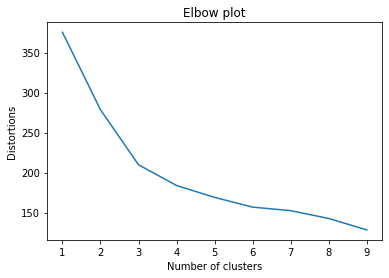

In [60]:
# Using the elbow method to find the optimal number of clusters
k = 10
distortions = []
for i in range(1, k):
    kmean_model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmean_model.fit(X)
    distortions.append(sum(np.min(cdist(X, kmean_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
plt.plot(range(1, k), distortions)
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

In [61]:
#According to the Elbow graph we deterrmine the clusters number as 4. 
#Applying k-means algorithm to the X dataset.
kmeans = KMeans(n_clusters=4, init ='k-means++', random_state=42)

y_kmeans = kmeans.fit_predict(X)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
#PCA
X_pca = X.copy()
pca = decomposition.PCA(n_components  = 2)
pca.fit(X_pca)
X_pca = pca.transform(X_pca)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


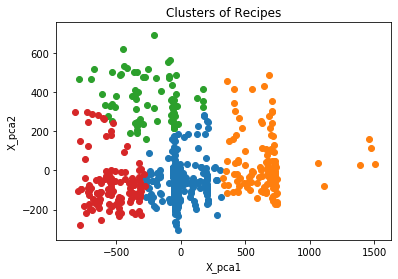

In [63]:
# Visualising the clusters
x = X_pca[0]
y = X_pca[1]

plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1])
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1])          
plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1])
plt.scatter(X_pca[y_kmeans == 3, 0], X_pca[y_kmeans == 3, 1])

#Plot the centroid, that is the cluster centres
#plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 8], s=200, c='yellow', label = 'Centroids')
plt.title('Clusters of Recipes')
plt.xlabel("X_pca1")
plt.ylabel("X_pca2")
plt.show()

In [64]:
#X = pd.DataFrame(X, columns = data.columns, index = data.index)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
X["cluster"] = y_kmeans

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
kmeans.cluster_centers_[:, 1]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 568.73714286,  612.63076923, 1006.59210526,  594.35294118])

### Statistical analysis of clusters

In [67]:
X.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,cooking_time,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter,topic,cluster
0,2,474,26,2,23,88,45,25,900,1400,2400,0,0,1,0,0,0,0
1,1,715,67,7,28,127,50,30,900,1400,2400,0,0,1,0,0,1,0
2,3,479,36,0,27,262,31,30,900,1200,2400,0,0,1,0,0,3,0
3,2,555,65,11,26,262,23,25,900,1400,2400,0,0,0,1,0,0,0
4,1,629,71,7,28,262,23,30,850,1150,1975,0,0,0,0,1,0,3


In [68]:
#data['cluster'] = X.cluster
#data.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
clustering_utils.get_statistics_clusters(X, columns=["carbs", "calories", "protein", "fat", "topic"]) 

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:25.242 | INFO     | game.clustering_utils:get_statistics_clusters:285 - cluster: 0
2020-09-21 09:39:25.279 | INFO     | game.clustering_utils:get_statistics_clusters:287 - 
             carbs    calories     protein         fat       topic
count  350.000000  350.000000  350.000000  350.000000  350.000000
mean    53.500000  568.737143   37.028571   23.474286    0.731429
std     17.778605   90.523720   12.223763    7.029057    1.230876
min     12.000000  335.000000    7.000000    7.000000    0.000000
25%     41.000000  506.000000   26.250000   19.000000    0.000000
50%     52.000000  563.000000   40.0

In [70]:
X['food_group'] = data.food_group

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
number_of_clusters = 4

dfs = []
for k in range(0, number_of_clusters):
    df = X.loc[X.cluster==k, :]
    logger.info(f"elements in cluster {k}: {len(df)}")
    dfs.append(X.loc[X.cluster==k, :])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:26.638 | INFO     | __main__:<module>:6 - elements in cluster 0: 350
2020-09-21 09:39:26.643 | INFO     | __main__:<module>:6 - elements in cluster 1: 130
2020-09-21 09:39:26.648 | INFO     | __main__:<module>:6 - elements in cluster 2: 76
2020-09-21 09:39:26.656 | INFO     | __main__:<module>:6 - elements in cluster 3: 119


In [72]:
dfs[0]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,cooking_time,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter,topic,cluster
0,2,474,26,2,23,88,45,25,900,1400,2400,0,0,1,0,0,0,0
1,1,715,67,7,28,127,50,30,900,1400,2400,0,0,1,0,0,1,0
2,3,479,36,0,27,262,31,30,900,1200,2400,0,0,1,0,0,3,0
3,2,555,65,11,26,262,23,25,900,1400,2400,0,0,0,1,0,0,0
8,1,530,61,0,22,262,26,25,900,1400,2400,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2,482,51,5,18,115,32,40,900,1400,2400,0,0,0,1,0,0,0
668,1,632,83,3,29,262,19,30,900,1400,2400,1,0,0,0,0,0,0
669,1,781,114,4,15,127,55,30,900,1400,2400,0,0,1,0,0,3,0
670,3,707,38,8,46,262,28,30,900,1400,2400,0,0,1,0,0,0,0


In [73]:
len(data[data.topic==0])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


505

In [74]:
len(data[data.topic==1])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19

In [75]:
len(data[data.topic==2])

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


54

### Topic statistics

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:31.508 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of topic


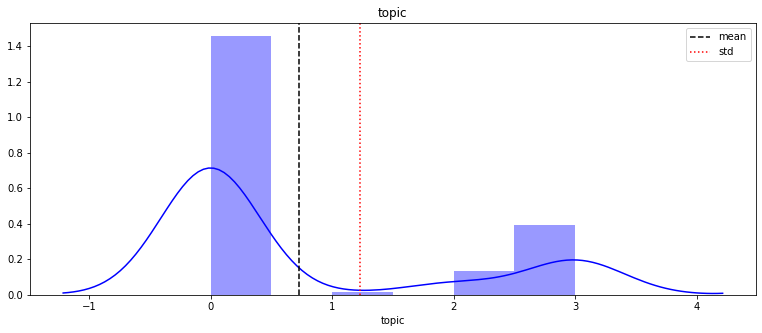

In [76]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[0], cluster=0, column="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:32.273 | INFO     | game.clustering_utils:get_hist_per_feature:321 - topic
0    255
1      3
2     23
3     69
Name: topic, dtype: int64


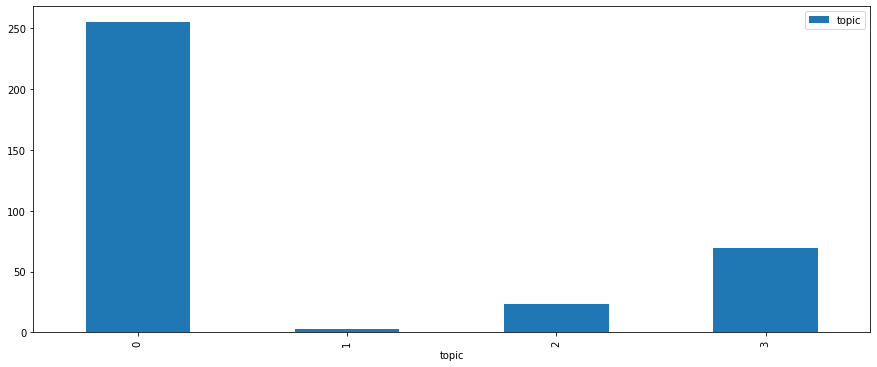

In [77]:
#dfs[0].groupby(by=["topic"])["topic"].agg(['count']).plot(kind="bar")
clustering_utils.get_hist_per_feature(dataframe=dfs[0], cluster=0, by_feature="topic", feature_to_count="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:32.984 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of topic


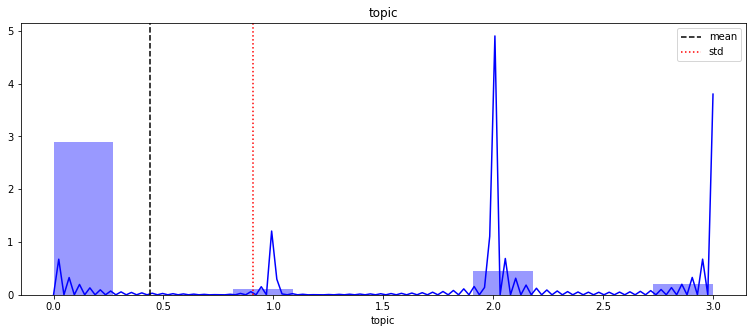

In [78]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[1], cluster=1, column="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:33.564 | INFO     | game.clustering_utils:get_hist_per_feature:321 - topic
0    103
1      4
2     16
3      7
Name: topic, dtype: int64


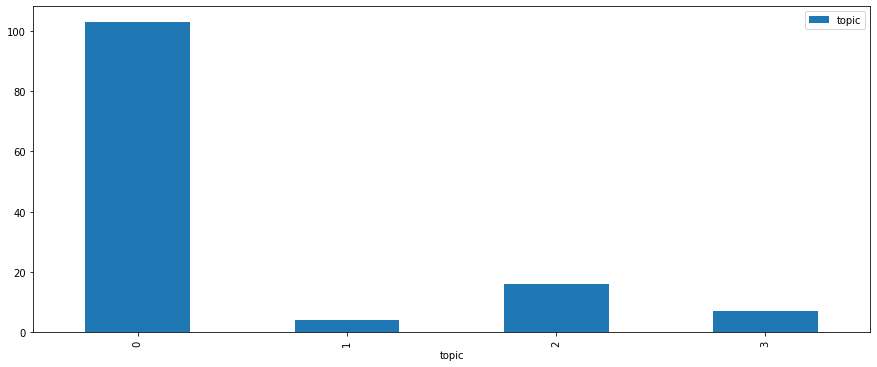

In [79]:
clustering_utils.get_hist_per_feature(dataframe=dfs[1], cluster=1, by_feature="topic", feature_to_count="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:34.308 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of topic


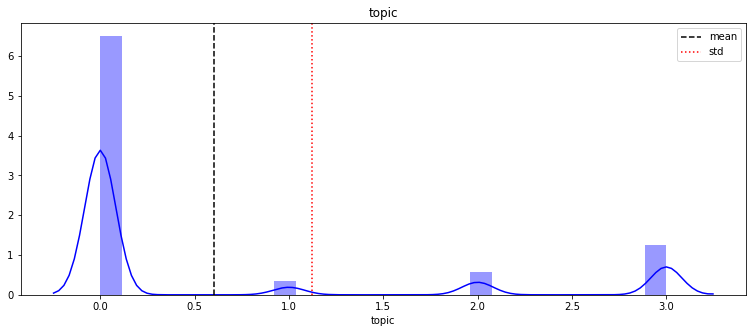

In [80]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[2], cluster=2, column="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:34.716 | INFO     | game.clustering_utils:get_hist_per_feature:321 - topic
0    57
1     3
2     5
3    11
Name: topic, dtype: int64


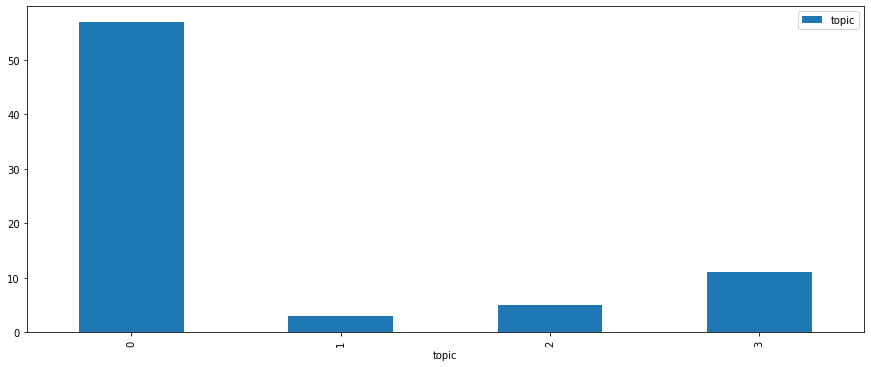

In [81]:
clustering_utils.get_hist_per_feature(dataframe=dfs[2], cluster=2, by_feature="topic", feature_to_count="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:39:35.487 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of topic


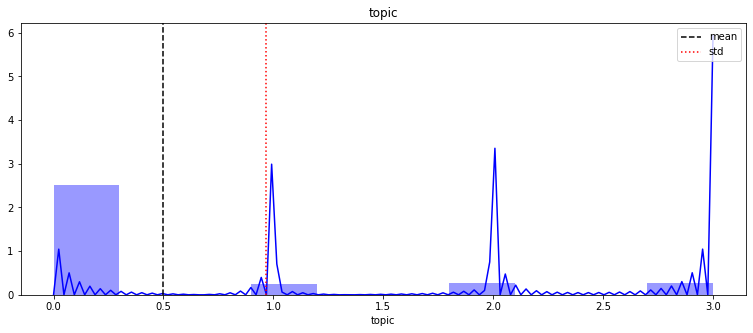

In [82]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[3], cluster=3, column="topic", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:41:22.096 | INFO     | game.clustering_utils:get_hist_per_feature:321 - topic
0    90
1     9
2    10
3    10
Name: topic, dtype: int64


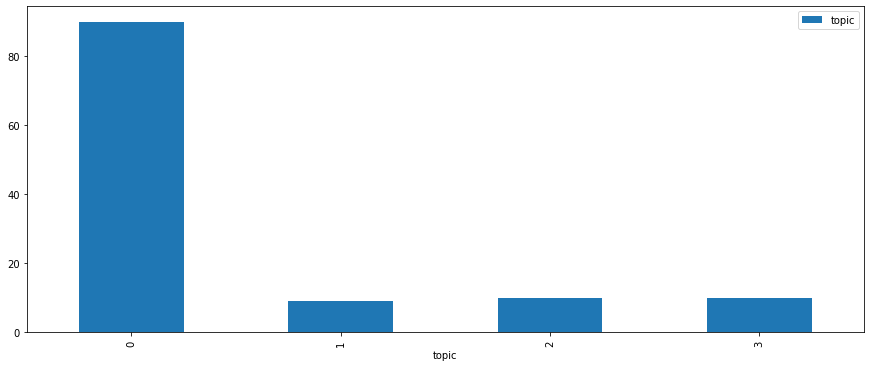

In [84]:
clustering_utils.get_hist_per_feature(dataframe=dfs[3], cluster=3, by_feature="topic", feature_to_count="topic", origin="notebook")

### Food group statistics

In [85]:
dfs[0].head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,cooking_time,price_1p_pence,price_2p_pence,price_4p_pence,season_autumn,season_other,season_spring,season_summer,season_winter,topic,cluster
0,2,474,26,2,23,88,45,25,900,1400,2400,0,0,1,0,0,0,0
1,1,715,67,7,28,127,50,30,900,1400,2400,0,0,1,0,0,1,0
2,3,479,36,0,27,262,31,30,900,1200,2400,0,0,1,0,0,3,0
3,2,555,65,11,26,262,23,25,900,1400,2400,0,0,0,1,0,0,0
8,1,530,61,0,22,262,26,25,900,1400,2400,1,0,0,0,0,0,0


/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:41:28.008 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of food_group


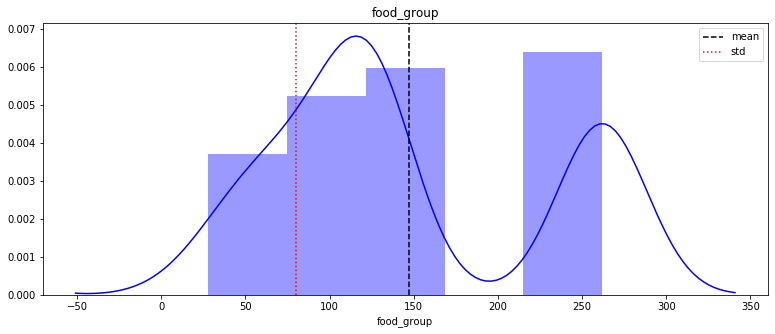

In [86]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[0], cluster=0, column="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:41:51.405 | INFO     | game.clustering_utils:get_hist_per_feature:321 - food_group
Beef        48
Chicken     98
Fish        38
Lamb        16
Pork        45
Vegan      105
Name: food_group, dtype: int64


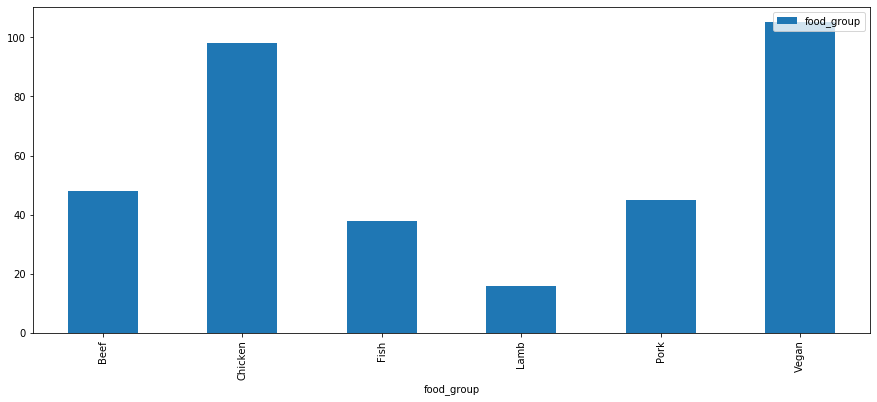

In [88]:
clustering_utils.get_hist_per_feature(dataframe=dfs[0].replace({"food_group": dict_food_group}), 
                                     cluster=0, by_feature="food_group", feature_to_count="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:41:54.475 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of food_group


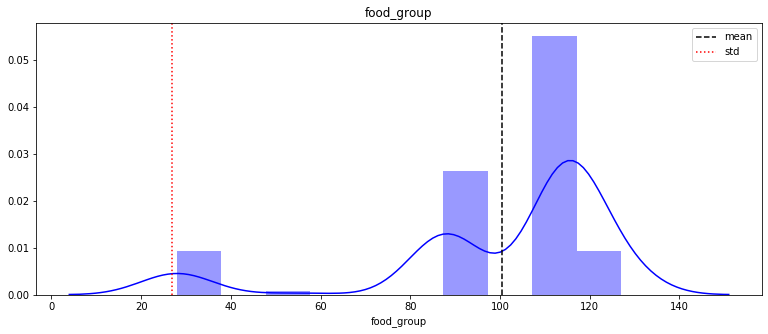

In [89]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[1], cluster=1, column="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:42:05.420 | INFO     | game.clustering_utils:get_hist_per_feature:321 - food_group
Beef       34
Chicken    12
Fish       71
Lamb       12
Pork        1
Name: food_group, dtype: int64


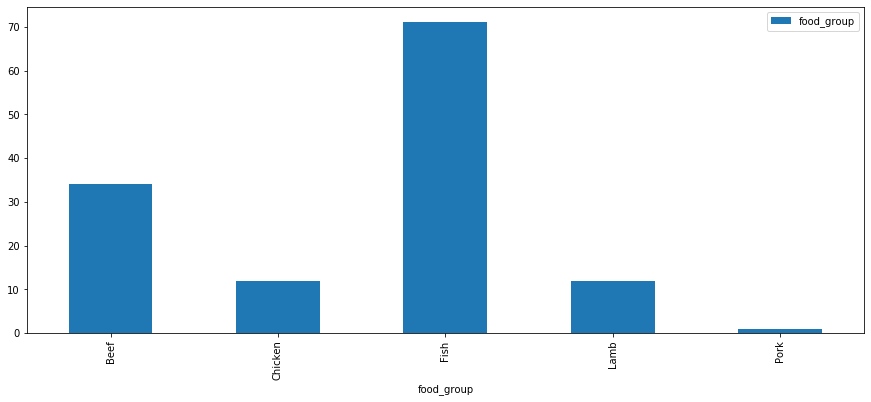

In [91]:
clustering_utils.get_hist_per_feature(dataframe=dfs[1].replace({"food_group": dict_food_group}), 
                                     cluster=1, by_feature="food_group", feature_to_count="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:42:06.358 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of food_group


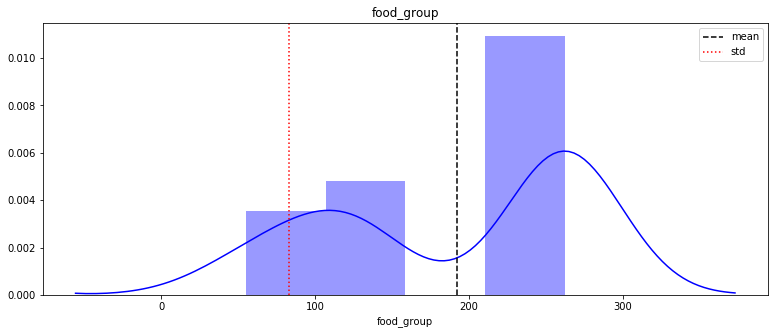

In [92]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[2], cluster=2, column="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:42:13.681 | INFO     | game.clustering_utils:get_hist_per_feature:321 - food_group
Beef        6
Chicken    14
Fish        5
Pork        8
Vegan      43
Name: food_group, dtype: int64


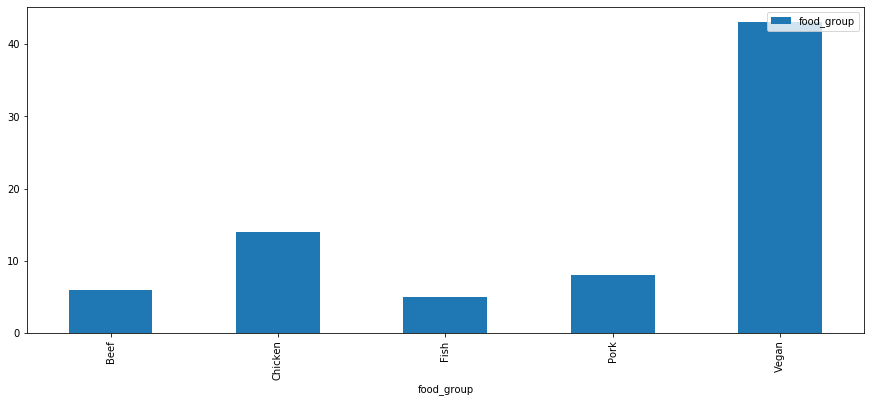

In [93]:
clustering_utils.get_hist_per_feature(dataframe=dfs[2].replace({"food_group": dict_food_group}), 
                                     cluster=2, by_feature="food_group", feature_to_count="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:42:16.548 | INFO     | game.clustering_utils:get_distribution_numerical_variable:305 - Distribution of food_group


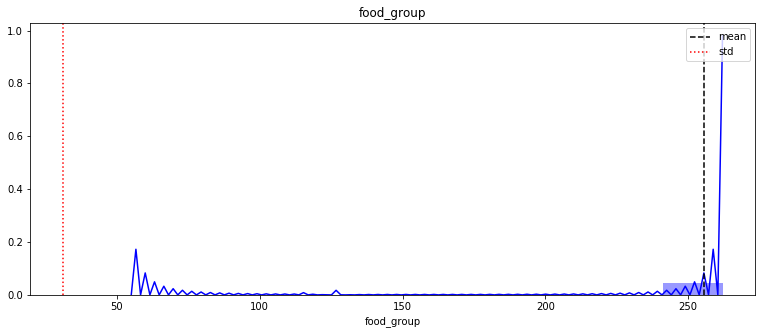

In [94]:
clustering_utils.get_distribution_numerical_variable(dataframe=dfs[3], cluster=3, column="food_group", origin="notebook")

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-21 09:42:26.243 | INFO     | game.clustering_utils:get_hist_per_feature:321 - food_group
Chicken      3
Fish         1
Pork         1
Vegan      114
Name: food_group, dtype: int64


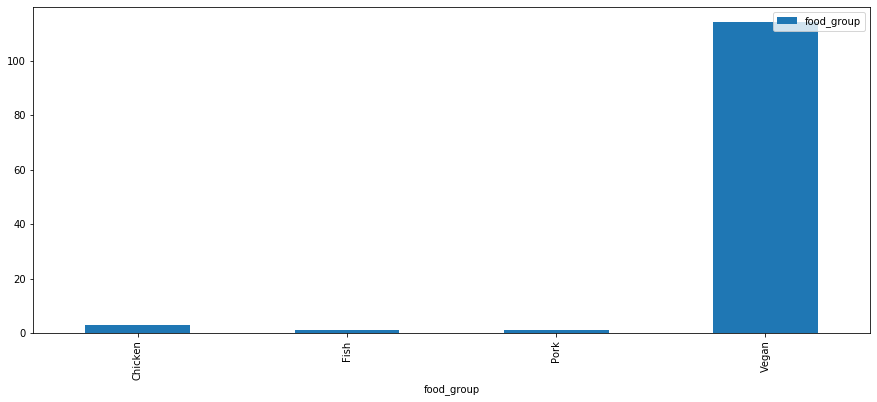

In [95]:
clustering_utils.get_hist_per_feature(dataframe=dfs[3].replace({"food_group": dict_food_group}), 
                                     cluster=3, by_feature="food_group", feature_to_count="food_group", origin="notebook")

### Data frame for game: recipe_ids per cluster

In [96]:
X['id'] = data.id
X.loc[5:10,['food_group','topic','cluster', 'id']]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,food_group,topic,cluster,id
5,55,3,2,15
6,127,2,3,16
7,88,0,1,17
8,262,0,0,18
9,262,3,3,20
10,262,0,3,21


In [97]:
X_game = X.groupby(['cluster'])["id"].agg(['count']).rename(columns={"count":"recipe_id_count"}).reset_index()
X_game.head()

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster,recipe_id_count
0,0,350
1,1,130
2,2,76
3,3,119


In [98]:
X_game = X.loc[:,['cluster', 'id']]
X_game.loc[680:685]

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster,id


In [99]:
X_game.sort_values("cluster", axis = 0, ascending = True, inplace = True)
X_game

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster,id
0,0,1
470,0,572
463,0,562
460,0,558
458,0,556
...,...,...
331,3,415
329,3,413
112,3,173
513,3,665


In [100]:
#X_game.to_csv(r'df_game.csv', index = False)

/Users/valentinanotararigo/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
